# Predict된 Reactant들을 Visualization

In [2]:
import os
import re
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolsToGridImage

In [3]:
exp_dir ='./data/real/'
    
pred_file = os.path.join(exp_dir, 'pred_results_203.txt')

In [4]:
class TreeNode:
    def __init__(self, value, no, smi):
        self.value = value
        self.no = no
        self.smi = smi
        self.children = {}

    def add_child(self, child_node):
        self.children[child_node.value] = child_node

    def print_tree(self, depth=0):
        prefix = "    " * depth
        print(f'{prefix} {self.no} {self.value} {self.smi}')
        for child_value, child_node in self.children.items():
            child_node.print_tree(depth + 1)

In [88]:
product=[]
reactant_process=[]

with open(pred_file, 'r', encoding='UTF8') as fp:

    line = None
    product_mole={}
    
    root = TreeNode('root', 0, '')
    while line !='':
        line = fp.readline()
        
        if 'p:' in line:
            layer_no =''

            no = re.match(r"\((\d+)\)", line)
            prod_no = int(no.group(1))
            start_index = line.index('p:[')
            smi = line[start_index+2:-1]
            product.append([prod_no, smi])
            
        elif 'pred_layer' in line:
            no = re.search(r"pred_layer(\d+):", line)
            layer_no = int(no.group(1))
            start_index = line.index('[')
            smi = line[start_index:-1]
            reactant_process.append(['l', prod_no,layer_no,'', smi])
        elif 'react_' in line:
            no = re.match(r"\s*react_l(\d+)_r(\d+):", line)
            layer_no = int(no.group(1))
            reactant_no =int(no.group(2))
            start_index = line.index('[')
            eMol_start_index = line.index('eMol:')
            smi = line[start_index:eMol_start_index]
            eMol_str=line[eMol_start_index+5:-1].replace(' ','')

            if eMol_str=='True':
                eMol = True
            elif eMol_str == 'False':
                eMol = False
            reactant_process.append(['r', prod_no,layer_no, reactant_no, smi, eMol])


In [14]:
def molecule_from_smiles(smiles):
    # MolFromSmiles(m, sanitize=True) should be equivalent to
    # MolFromSmiles(m, sanitize=False) -> SanitizeMol(m) -> AssignStereochemistry(m, ...)
    
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    # If sanitization is unsuccessful, catch the error, and try again without
    # the sanitization step that caused the error
  
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule

In [89]:
df_product = pd.DataFrame(product, columns=['product_no', 'product_smi'])
df_reactant = pd.DataFrame(reactant_process, columns=['lr','product_no', 'layer_no','reactant_no','smi','eMol'])

## 역합성이 성공했는지 검사

In [234]:
def inspect_reaction_success(product_no, df_reactant, df_product ):
 
    reactant_success = df_reactant[df_reactant['product_no']== product_no][['lr', 'product_no', 'layer_no', 'reactant_no', 'eMol']]
    if len(reactant_success)==0:return
    reactant_success = reactant_success.sort_values(by='layer_no', ascending=False)
    reactant_success = reactant_success[reactant_success['lr']=='r']
    max_layer_no = reactant_success['layer_no'].max()

    for layer_no in range(max_layer_no,0,-1):
        r1 = reactant_success.loc[(reactant_success['layer_no']==layer_no) & (reactant_success['reactant_no']==1) ]['eMol']
        r2 = reactant_success.loc[(reactant_success['layer_no']==layer_no) & (reactant_success['reactant_no']==2) ]['eMol']
        if len(r1)>0 and len(r2)>0:
            if (r1.iloc[0]==r2.iloc[0]) & (r1.iloc[0]==True):
                before_layer = reactant_success.loc[(reactant_success['layer_no']==(layer_no-1)) & (reactant_success['eMol']==False) ]
                if len(before_layer)==1:
                    index_to_update = before_layer.index[0]
                    reactant_success.at[index_to_update, 'eMol'] = True

    False_check = reactant_success.loc[(reactant_success['eMol']==False)]

    if len(False_check)==0:
        success = True
    else:
        success = False

    product = df_product[df_product['product_no']==product_no]
    product_index = product.index[0]
    df_product.at[product_index, 'success'] = success 



## product 전체에 대한 검사 진행

In [239]:

for product_no in enumerate(df_product['product_no']):
    inspect_reaction_success(product_no[1],df_reactant,df_product)


In [238]:
df_product[df_product['success']==True]

,product_no,product_smi,success
3,3,[CH3:1][C:2](=[O:3])[O:4][CH:5]([CH3:6])[CH:7]...,True
5,5,[CH2:1]=[C:2]([CH3:3])[CH:4]([C:5]#[N:6])[C:7]...,True
33,33,[CH2:1]=[C:2]([CH3:3])[C:4](=[O:5])[CH:6]([CH3...,True
49,49,[CH3:1][CH:2]=[C:3]([CH3:4])[S:5][c:6]1[cH:7][...,True
54,54,[CH2:1]=[C:2]([CH3:3])[CH2:4][c:5]1[n:6][c:7](...,True
...,...,...,...
1476,1476,[CH3:1][CH2:2][CH2:3][CH2:4][CH2:5][C:6](=[O:7...,True
1481,1481,[CH2:1]=[C:2]([CH3:3])[n:4]1[cH:5][c:6]([CH3:7...,True
1492,1492,[CH3:1][CH2:2][CH2:3][CH2:4][c:5]1[n:6][c:7]([...,True
1496,1496,[CH3:1][CH:2]([CH3:3])[CH:4]1[CH2:5][O:6][N:7]...,True


## Product_no를 가지고 Molecule을 그려보자

33 [CH2:1]=[C:2]([CH3:3])[C:4](=[O:5])[CH:6]([CH3:7])[S:8](=[O:9])[c:10]1[cH:11][cH:12][cH:13][c:14]([F:15])[cH:16]1


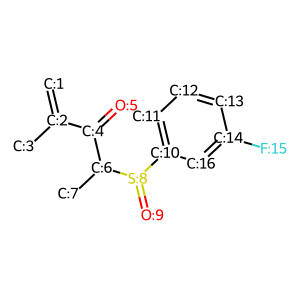

In [241]:
product_no = 33
this_product = df_product[df_product['product_no']==product_no]
this_df = df_reactant[df_reactant['product_no']== product_no]
product_smi = this_product['product_smi'].iloc[0] 
print(product_no, product_smi)
molecule= Chem.MolFromSmiles(product_smi, sanitize=False)
Draw.MolToImage(molecule)
#Draw.MolToMPL(molecule)

In [242]:
df_reactant[df_reactant['product_no']== product_no]

,lr,product_no,layer_no,reactant_no,smi,eMol
194,l,33,1,,[CH2:1]=[C:2]([CH3:3])[C:4](=[O:5])[CH:6]([CH3...,None
195,r,33,1,1,[O:1]=[C:2]([O:3][OH:4])[c:5]1[cH:6][cH:7][cH:...,True
196,r,33,1,2,[CH2:1]=[C:2]([CH3:3])[C:4](=[O:5])[CH:6]([CH3...,False
197,l,33,2,,[CH2:1]=[C:2]([CH3:3])[C:4](=[O:5])[CH:6]([CH3...,None
198,r,33,2,1,[F:1][c:2]1[cH:3][cH:4][cH:5][c:6]([SH:7])[cH:...,True
199,r,33,2,2,[CH2:1]=[C:2]([CH3:3])[C:4](=[O:5])[CH:6]([CH3...,False
200,l,33,3,,[CH2:1]=[C:2]([CH3:3])[C:4](=[O:5])[CH2:6][CH3...,None
201,r,33,3,1,[CH2:1]=[C:2]([CH3:3])[C:4](=[O:5])[CH2:6][CH3...,True
202,r,33,3,2,[O:1]=[C:2]1[CH2:3][CH2:4][C:5](=[O:6])[N:7]1[...,True


In [243]:
# product_no는 위에서 정의
this_df = df_reactant[df_reactant['product_no']== product_no]
reactant_seq = 0 
reactant_list = []
for i,row in this_df.iterrows():
    lr = row['lr']
    layer_no = row['layer_no']
    reactatnt_no = row['reactant_no']
    smi = row['smi']
    eMol = row['eMol']
    
    if lr=='l':
        print(f"{'    ' * int(layer_no)}level{layer_no} {smi} eMol:{eMol}")
    elif lr=='r':
        reactant_seq +=1
        
        print(f"{'    ' * (int(layer_no)+1)} ({reactant_seq}) r{reactatnt_no} {smi} eMol:{eMol}")
        reactant_list.append([reactant_seq,smi])

    level1 [CH2:1]=[C:2]([CH3:3])[C:4](=[O:5])[CH:6]([CH3:7])[S:8][c:9]1[cH:10][cH:11][cH:12][c:13]([F:14])[cH:15]1.[O:16]=[C:17]([O:18][OH:19])[c:20]1[cH:21][cH:22][cH:23][c:24]([Cl:25])[cH:26]1 eMol:None
         (1) r1 [O:1]=[C:2]([O:3][OH:4])[c:5]1[cH:6][cH:7][cH:8][c:9]([Cl:10])[cH:11]1    eMol:True
         (2) r2 [CH2:1]=[C:2]([CH3:3])[C:4](=[O:5])[CH:6]([CH3:7])[S:8][c:9]1[cH:10][cH:11][cH:12][c:13]([F:14])[cH:15]1    eMol:False
        level2 [CH2:1]=[C:2]([CH3:3])[C:4](=[O:5])[CH:6]([CH3:7])[Br:8].[F:9][c:10]1[cH:11][cH:12][cH:13][c:14]([SH:15])[cH:16]1 eMol:None
             (3) r1 [F:1][c:2]1[cH:3][cH:4][cH:5][c:6]([SH:7])[cH:8]1    eMol:True
             (4) r2 [CH2:1]=[C:2]([CH3:3])[C:4](=[O:5])[CH:6]([CH3:7])[Br:8]    eMol:False
            level3 [CH2:1]=[C:2]([CH3:3])[C:4](=[O:5])[CH2:6][CH3:7].[O:8]=[C:9]1[CH2:10][CH2:11][C:12](=[O:13])[N:14]1[Br:15] eMol:None
                 (5) r1 [CH2:1]=[C:2]([CH3:3])[C:4](=[O:5])[CH2:6][CH3:7]    eMol:True
                 (6) r

## Product_no에 따라 Reactant 생성된 것을 모두 Visualization

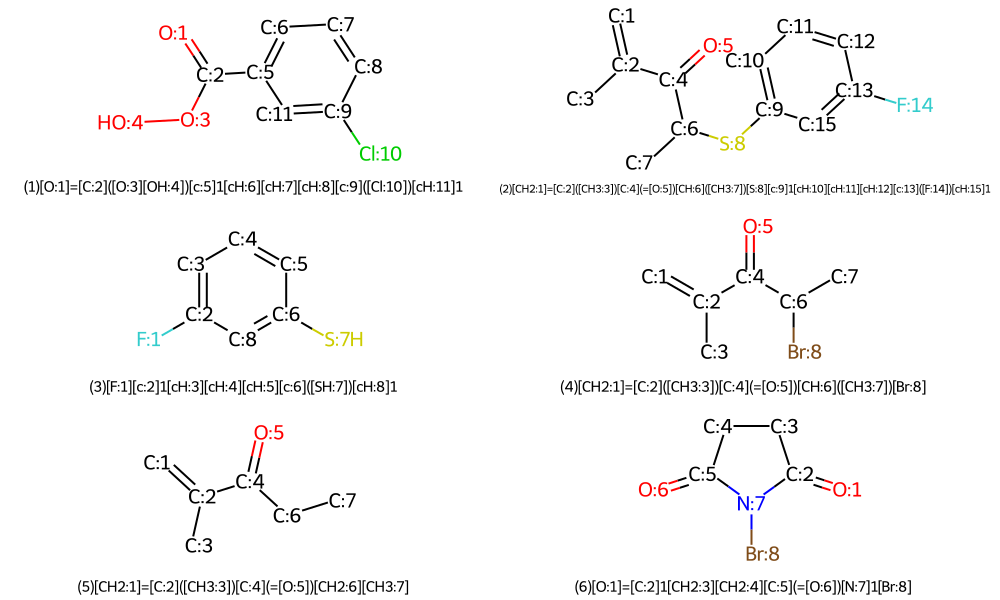

In [244]:
molecules = [molecule_from_smiles(smi[1]) for smi in reactant_list]
legends = [ f"({i[0]}){i[1]}" for i in reactant_list]
MolsToGridImage(molecules, molsPerRow=2, subImgSize=(500, 200), legends=legends, useSVG=True)